# Porównanie skuteczności klasyfikatorów SVM i AdaBoost na zbiorach danych o wymiarowości zredukowanej przez autoenkoder wariacyjny

## Przygotowanie zbioru danych

In [1]:
%matplotlib inline

import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [47]:
with zipfile.ZipFile("data/fashion-mnist.zip") as z:
    with z.open("fashion-mnist_train.csv") as f:
        train_df = pd.read_csv(f)

    with z.open("fashion-mnist_test.csv") as f:
        test_df = pd.read_csv(f)

train_labels = train_df['label'].to_numpy()
train_data = train_df.drop('label', axis='columns').to_numpy() / 255.0

test_labels = test_df['label'].to_numpy()
test_data = test_df.drop('label', axis='columns').to_numpy() / 255.0

W projekcie wykorzystujemy zbiór danych FMNIST.

Jako że jest to bardzo znany i dokładnie opisany zbiór danych, etap eksploracji danych ograniczyliśmy do minimum - wszelkie ważne własności zbioru zostały już zbadane, więc sprawdzanie ich w miarę potrzeb nie nastręcza większych trudności. Tutaj zaglądamy jedynie na początek danych oraz podstawową ich charakterystykę, aby upewnić się, że wszystko jest w porządku.

In [3]:
def print_images(images, title):
    fig, axs = plt.subplots(ncols=5, figsize=(13,4))
    
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    fig.tight_layout()
    fig.suptitle(title, fontsize=15)
    plt.show()

Liczba próbek w zbiorze uczącym: 60000
Liczba próbek w zbiorze testowym: 10000

Kształt wektora wejściowego: (784,)
Zakres wartości pikseli przed normalizacją: 0 - 255


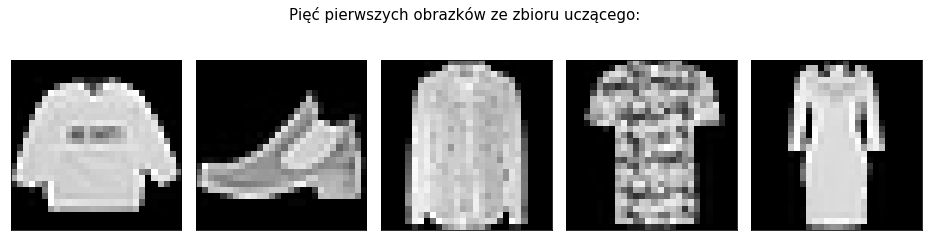

Reprezentacja pierwszych 5 próbek w zbiorze uczącym:

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel78

In [34]:
print(f'Liczba próbek w zbiorze uczącym: {len(train_df)}')
print(f'Liczba próbek w zbiorze testowym: {len(test_df)}')
print()
print(f'Kształt wektora wejściowego: {np.shape(train[0])}')
print(f'Zakres wartości pikseli przed normalizacją: {np.min(train_df.to_numpy())} - {np.max(train_df.to_numpy())}')

first_5_images = train_df.head().drop('label', axis='columns').to_numpy().reshape((5,28,28))
print_images(first_5_images, 'Pięć pierwszych obrazków ze zbioru uczącego:')
    
print('Reprezentacja pierwszych 5 próbek w zbiorze uczącym:\n')
print(train_df.head())

## Redukcja wymiarowości za pomocą autoenkodera wariacyjnego

In [35]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from enum import Enum

### Załadowanie modeli

Modele zostały zbudowane i wytrenowane w osobnym notatniku Jupyter: *'Autoenkodery - tworzenie i trening'*.

W ramach projektu wykorzystano 3 architektury sieci - są to (wg rosnącej złożoności):
 * enkoder wariacyjny z 2 warstwami ukrytymi
 * enkoder wariacyjny z 4 warstwami ukrytymi
 * enkoder konwolucyjno-wariacyjny

Każda z architektur została wytrenowana w trzech wersjach - dla 15, 50 i 100 wymiarów w środkowej warstwie sieci.

Trening sieci o bardziej złożonej architekturze wymaga więcej czasu - w tym przypadku, pojedyncza epoka treningu najbardziej złożonej sieci (konwolucyjno-wariacyjnej) trwała 10 razy dłużej niż najprostszej z nich (2 warstwy ukryte). Wykorzystanie modeli o różnej złożoności odpowiada zatem posiadaniu odpowiednio zróżnicowanego budżetu czasowego.

In [135]:
z_mean, z_variance = None, None

def load_model(model_name):
    with open(f'autoencoders/models/{model_name}.json') as file:
        loaded_json = file.read()
    return model_from_json(loaded_json)

def load_weights(model, model_name, epochs):
    model.load_weights(f'autoencoders/weights/{model_name}_e{epochs}.h5')

def load_encoder(time, dim, epochs=400):
    global z_mean, z_variance
    
    encoder_name = f'encoder_{time.value}_d{dim.value}'
    
    encoder = load_model(encoder_name)
    load_weights(encoder, encoder_name, epochs)
    
    z_mean, z_variance = encoder.get_layer('z_mean').output, encoder.get_layer('z_variance').output
    encoder.compile(optimizer='rmsprop', loss=vae_loss)
    
    return encoder

In [137]:
class Time(Enum):
    SHORT = '2hl'
    MEDIUM = '4hl'
    LONG = 'cvae'

class Dim(Enum):
    LOW = 15
    MEDIUM = 50
    HIGH = 100

# encoders[dimension][time]

encoders = {dim: {time: load_encoder(time, dim, 400 if time != Time.LONG else 300) for time in Time} for dim in Dim}

### Generowanie zbiorów danych o zredukowanej wymiarowości

In [138]:
batch_size = 10000
initial_dim = 784

In [139]:
# reduced_datasets[Dim][Time]['train'|'test']

def reduce_dimensionality(train, test):
    return {
                dim: {
                    time: {
                        'train': encoders[dim][time].predict(train, batch_size=batch_size),
                        'test': encoders[dim][time].predict(test, batch_size=batch_size)
                    } for time in Time
                } for dim in Dim
            }

def map_over_reduced(reduced_datasets, f, args):
    return {dim: {
                time: {
                    key: f(reduced_datasets[dim][time][key], *args) for key in reduced_datasets[dim][time]
                } for time in reduced_datasets[dim].keys()
            } for dim in reduced_datasets.keys()}

In [140]:
reduced_datasets = reduce_dimensionality(train, test)

## Klasyfikacja

In [151]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

In [152]:
from joblib import dump, load

In [153]:
def get_classifier_filename(name, dim, time, noise_factor, noise_type):
    return f'{name}_d{dim.value}_e{time.value}' + (
        f'_n{str(noise_factor).split(".")[1]}_{noise_type}' if noise_type is not None else ''
    )

def get_orig_classifier_filename(name, noise_factor, noise_type):
    return f'{name}_orig' + (f'_{str(noise_factor).split(".")[1]}_{noise_type}' if noise_type is not None else '')

def get_classifier_path(name, filename):
    return f'{name}/{filename}'

def persist_classifier(classifier, name, dim, time, noise_factor, noise_type):
    filename = get_classifier_filename(name, dim, time, noise_factor)
    path = get_classifier_path(name, filename)
    dump(classifier, path)

def load_classifier(name, dim, time, noise_factor, noise_type):
    filename = get_classifier_filename(name, dim, time, noise_factor)
    path = get_classifier_path(name, filename)
    return load(path)

def persist_fitted_clfs(name, orig, applied, noise_factor, noise_type):
    orig_fitted, _ = orig
    persist_orig_classifier(orig_fitted, noise_factor, noise_type)
    
    for dim, time, (fitted, _) in applied:
        persist_classifier(fitted, name, dim, time, noise_factor, noise_type)

In [156]:
def fit_predict(model, train_data, train_labels, test_data):
    print(f'Fitting model {model}')
    
    fitted = model.fit(train_data, train_labels)

    print(f'Predicting with model {model}')
    
    predicted = fitted.predict(test_data)
    
    print()
    
    return fitted, predicted

def apply_classifier(classifier_class, original_dataset, reduced_datasets):
    orig_train_data, orig_train_labels, orig_test_data, orig_test_labels = original_dataset
    
    orig = fit_predict(classifier_class(), orig_train_data, orig_train_labels, orig_test_data)
    
    applied = [(dim, time, fit_predict(classifier_class(),
                                       reduced_datasets[dim][time]['train'],
                                       orig_train_labels,
                                       reduced_datasets[dim][time]['test']
                                       ))
              for dim in Dim for time in Time]
    
    return orig, applied  

def print_accuracy_scores(classifier_name, orig, applied, original_dataset):
    _, orig_predicted = orig
    _, _, _, orig_test_labels = original_dataset
    
    print(f'{classifier_name} accuracy scores:')
    print(f'original dataset: {accuracy_score(orig_test_labels, orig_predicted)}')
    
    for dim, time, (_, predicted) in applied:
        print(f'dimension {dim.name}, time {time.name}: {accuracy_score(orig_test_labels, predicted)}')

def print_classification_reports(classifier_name, orig, applied, original_dataset):
    _, orig_predicted = orig
    _, _, _, orig_test_labels = original_dataset
    
    print('----- Classification for original dataset -----')
    print(classification_report(orig_test_labels, orig_predicted))
    
    for dim, time, (_, predicted) in applied:
        print(f'----- Classification for dimension {dim.name}, time {time.name} -----')
        print(classification_report(orig_test_labels, predicted))

### AdaBoost

In [155]:
def measure_adaboost(original_dataset, reduced_datasets, noise_factor=0.0, noise_type=None):
    orig, applied = apply_classifier(AdaBoostClassifier, original_dataset, reduced_datasets)
    
    persist_fitted_clfs('adaboost', orig, applied, noise_factor, noise_type)
    
    print_accuracy_scores('AdaBoost', orig, applied)

In [ ]:
measure_adaboost((train_data, train_labels, test_data, test_labels), reduced_datasets)

Fitting model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predicting with model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Fitting model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predicting with model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Fitting model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


### SVM

In [85]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [106]:
def limited(array, n):
    return array[:n] if len(array) > n else array

def limit_dataset(dataset, target_number_of_samples):
    return (limited(array, target_number_of_samples) for array in dataset)

In [150]:
def measure_svc(original_dataset, reduced_datasets, sample_limit=10000, noise_factor=0.0, noise_type=None):
    limited_dataset = limit_dataset(original_dataset)
    limited_reduced_datasets = map_over_reduced(reduced_datasets, limited, (sample_limit,))
    
    orig, applied = apply_classifier(SVC, limited_dataset, limited_reduced_datasets)
    
    persist_fitted_clfs('svm', orig, applied, noise_factor, noise_type)
    
    print_classification_reports('SVC', orig, applied, limited_dataset)

In [ ]:
measure_svc((train_data, train_labels, test_data, test_labels), reduced_datasets)

## Pomiar odporności klasyfikatorów na zaszumione dane (*robustness*)

### Zaszumienie wektorów danych

In [133]:
def noisify_vectors(data, noise_factor):    
    vector_length = len(data[0])
    number_of_samples = len(data)
    epsilon = (np.random.rand(number_of_samples, vector_length) - 0.5) * 2 * 255 * noise_factor
    new_data = data + epsilon
    bounded = lambda p: min(max(p, 0), 255)
    return np.vectorize(bounded)(new_data)

In [ ]:
noise_factors = np.linspace(0.1, 0.5, 3)
noise_type = 'vectors'

for noise_factor in noise_factors:
    noisy_train_data = noisify_vectors(train_data, noise_factor)
    noisy_test_data = noisify_vectors(test_data)
    
    noisy_original_dataset = (noisy_train_data, train_labels, noisy_test_data, test_labels)
    
    noisy_reduced_datasets = reduce_dimensionality(noisy_train_data, noisy_test_data)
    
    measure_adaboost(noisy_original_dataset, noisy_reduced_datasets, noise_factor, noise_type)
    measure_svm(noisy_original_dataset, noisy_reduced_datasets, noise_factor, noise_type)

### Zaszumienie etykiet

In [119]:
from copy import deepcopy

def noisify_labels(labels, ratio):
    new_labels = deepcopy(labels)
    distinct_labels = np.unique(labels)
    indices = np.random.choice(len(labels), int(ratio * len(labels)), replace=False)
    for i in indices:
        current_label = new_labels[i]
        possible_labels = [l for l in distinct_labels if l != current_label]
        new_labels[i] = np.random.choice(possible_labels, 1)[0]
    return new_labels

In [ ]:
noise_factors = np.linspace(0.1, 0.5, 3)
noise_type = 'labels'

for noise_factor in noise_factors:
    noisified_original_dataset = (train_data, noisify_labels(train_labels), test_data, test_labels)
    
    measure_adaboost(noisified_original_dataset, reduced_datasets, noise_factor, noise_type)
    measure_svm(noisified_original_dataset, reduced_datasets, noise_factor, noise_type)

## Źródła

* https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726
* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://www.tensorflow.org/tutorials/generative/cvae
* https://towardsdatascience.com/the-robustness-of-machine-learning-algorithms-against-missing-or-abnormal-values-ec3222379905